<a href="https://colab.research.google.com/github/JYoung998/Quant-Projects/blob/main/DynamicDelta_HedgingSimualator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Simulating Delta Hedging for a Single Call Option ---
Final PnL for single option: 9.90


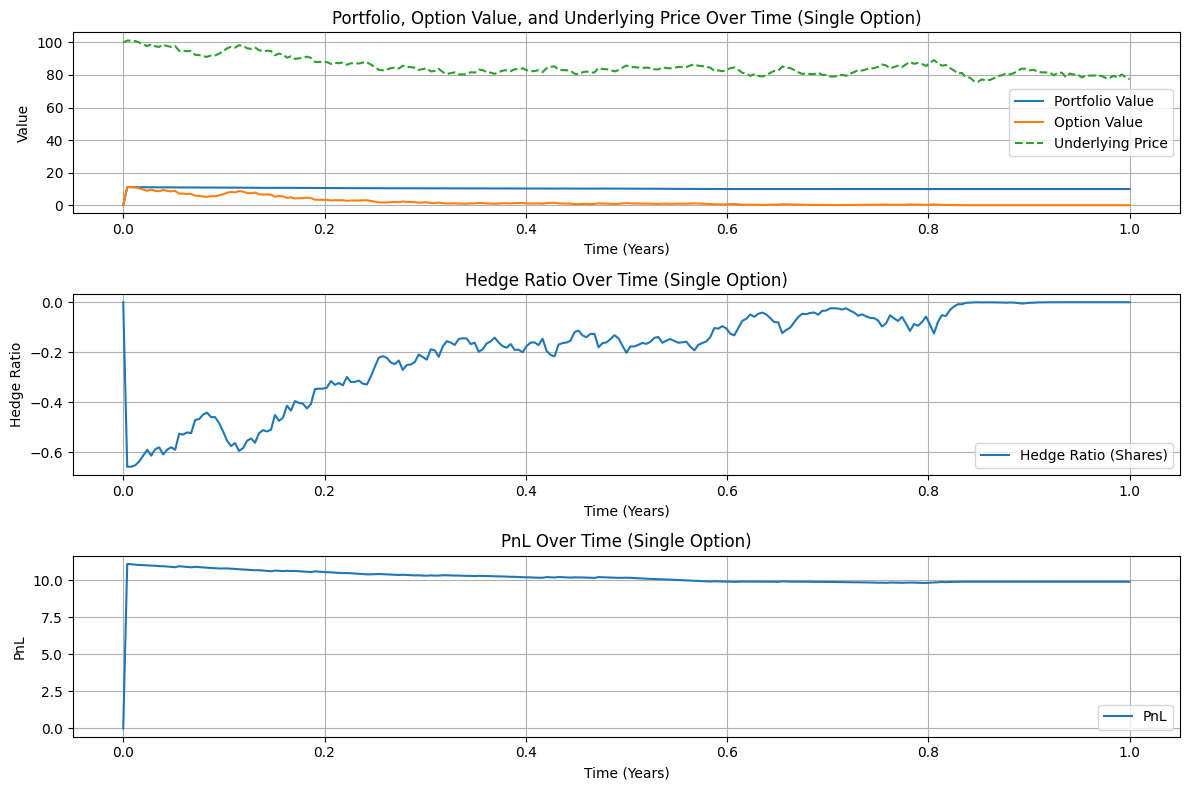


--- Simulating Delta Hedging for a Portfolio of Options ---
Final PnL for portfolio: 23.58


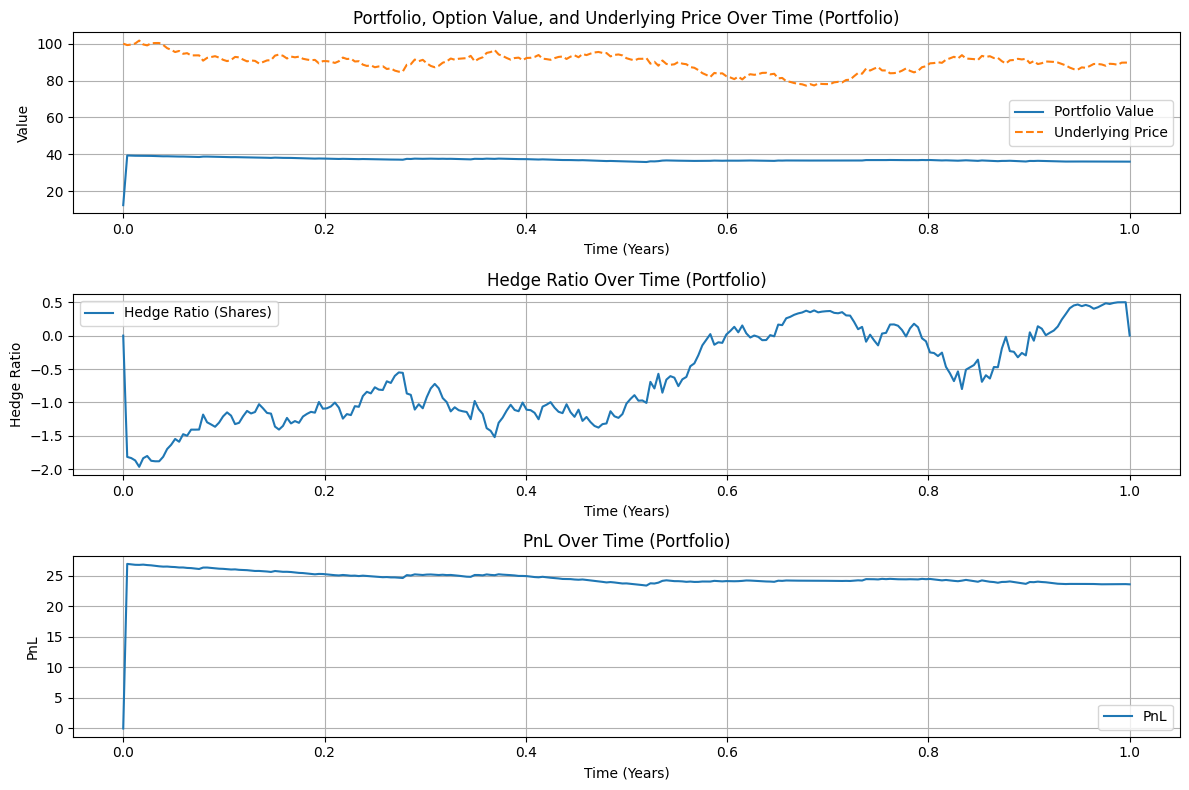


--- Performing Sensitivity Analysis (Varying Volatility) ---
Running simulation for sigma = 0.1
Running simulation for sigma = 0.2
Running simulation for sigma = 0.3


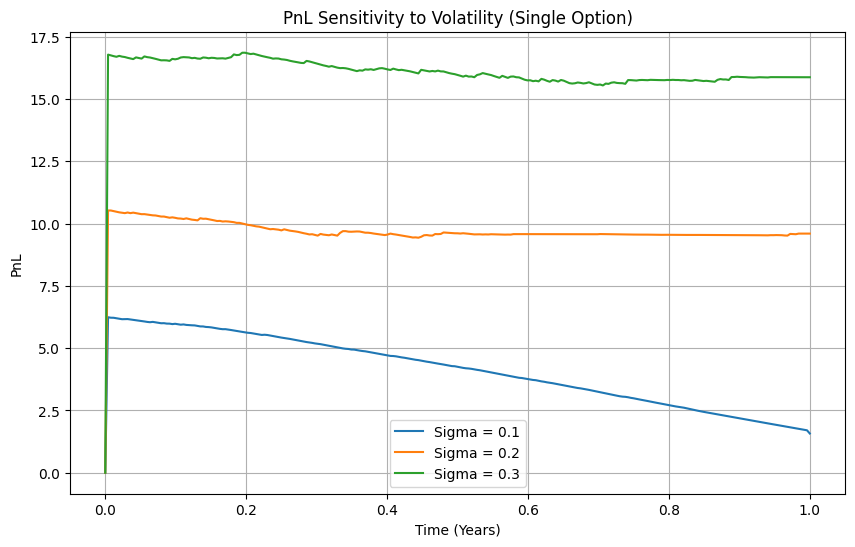


--- Performing Sensitivity Analysis (Varying Interest Rate) ---
Running simulation for r = 0.03
Running simulation for r = 0.05
Running simulation for r = 0.07


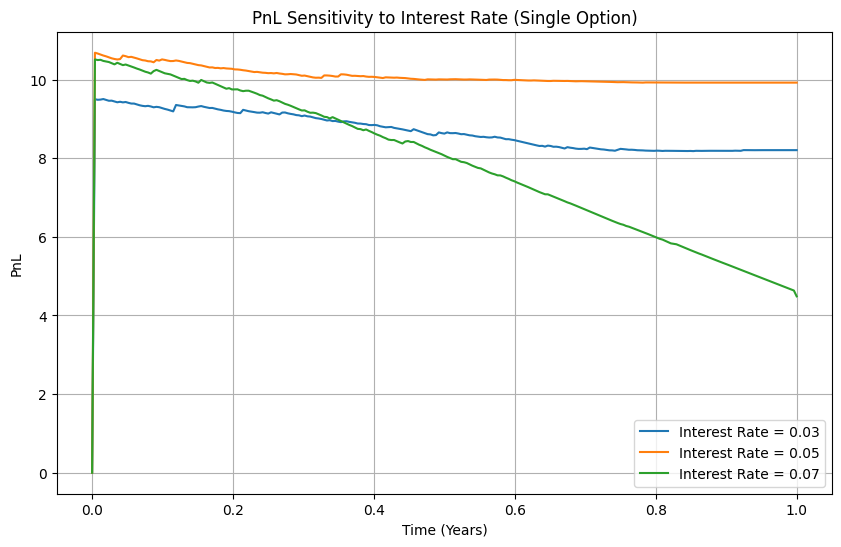

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. Black-Scholes Pricing
def black_scholes(S, K, T, r, sigma, option_type):
    """
    Calculates Black-Scholes option price and delta.

    Args:
        S (float): Underlying asset price.
        K (float): Option strike price.
        T (float): Time to expiration (in years).
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        option_type (str): 'call' or 'put'.

    Returns:
        tuple: (option_price, delta)
    """
    # Handle time to expiration being zero or negative
    if T <= 0:
        if option_type == 'call':
            return max(0, S - K), 0
        elif option_type == 'put':
            return max(0, K - S), 0
        else:
            raise ValueError("option_type must be 'call' or 'put'")


    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        delta = norm.cdf(d1) - 1
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return option_price, delta

# 2. Geometric Brownian Motion Simulation
def simulate_gbm(S0, T, r, sigma, dt, num_steps):
    """
    Simulates underlying asset price path using Geometric Brownian Motion.

    Args:
        S0 (float): Initial underlying asset price.
        T (float): Total time horizon (in years).
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        dt (float): Time step size.
        num_steps (int): Number of simulation steps.

    Returns:
        numpy.ndarray: Array of simulated prices over time.
    """
    price_path = np.zeros(num_steps + 1)
    price_path[0] = S0
    for i in range(num_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        price_path[i+1] = price_path[i] * np.exp((r - 0.5 * sigma**2) * dt + sigma * dW)
    return price_path

# 3. Dynamic Delta Hedging Simulation
def simulate_delta_hedging(S0, K, T, r, sigma, option_type, dt, num_steps, transaction_cost_rate, rebalancing_frequency_steps):
    """
    Simulates dynamic delta hedging for a single option.

    Args:
        S0 (float): Initial underlying asset price.
        K (float): Option strike price.
        T (float): Time to expiration (in years).
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        option_type (str): 'call' or 'put'.
        dt (float): Time step size.
        num_steps (int): Number of simulation steps.
        transaction_cost_rate (float): Transaction cost as a percentage of the trade value.
        rebalancing_frequency_steps (int): Number of steps between rebalancing.

    Returns:
        dict: Dictionary containing simulation results (PnL, hedge ratio, option value, portfolio value).
    """
    price_path = simulate_gbm(S0, T, r, sigma, dt, num_steps)
    time_points = np.linspace(0, T, num_steps + 1)

    option_values = np.zeros(num_steps + 1)
    deltas = np.zeros(num_steps + 1)
    hedge_ratios = np.zeros(num_steps + 1)
    cash_flows = np.zeros(num_steps + 1)
    portfolio_values = np.zeros(num_steps + 1)
    shares_held = np.zeros(num_steps + 1)
    transaction_costs = np.zeros(num_steps + 1)

    # Initial state (time t=0)
    option_values[0], deltas[0] = black_scholes(price_path[0], K, time_points[0], r, sigma, option_type)
    hedge_ratios[0] = -deltas[0]  # Short delta shares to hedge
    shares_held[0] = hedge_ratios[0]
    cash_flows[0] = -shares_held[0] * price_path[0]  # Initial cost of shares
    portfolio_values[0] = option_values[0] + shares_held[0] * price_path[0] + cash_flows[0]


    for i in range(1, num_steps + 1):
        current_time = time_points[i]
        time_to_expiration = T - current_time

        if time_to_expiration <= 0:
            # Option expires
            option_values[i] = max(0, price_path[i] - K) if option_type == 'call' else max(0, K - price_path[i])
            deltas[i] = 0
            hedge_ratios[i] = 0
            # Liquidate remaining shares
            shares_to_trade = 0 - shares_held[i-1]
            trade_value = shares_to_trade * price_path[i]
            transaction_cost = abs(trade_value) * transaction_cost_rate
            cash_flows[i] = -trade_value - transaction_cost
            transaction_costs[i] = transaction_cost
            shares_held[i] = 0
        else:
            option_values[i], deltas[i] = black_scholes(price_path[i], K, time_to_expiration, r, sigma, option_type)
            hedge_ratios[i] = -deltas[i]

            # Rebalance hedge
            if i % rebalancing_frequency_steps == 0:
                shares_to_trade = hedge_ratios[i] - shares_held[i-1]
                trade_value = shares_to_trade * price_path[i]
                transaction_cost = abs(trade_value) * transaction_cost_rate
                cash_flows[i] = -trade_value - transaction_cost
                transaction_costs[i] = transaction_cost
                shares_held[i] = shares_held[i-1] + shares_to_trade
            else:
                shares_held[i] = shares_held[i-1]
                cash_flows[i] = 0
                transaction_costs[i] = 0

        # Update portfolio value
        portfolio_values[i] = option_values[i] + shares_held[i] * price_path[i] + np.sum(cash_flows[:i+1])

    # Calculate PnL (difference between final portfolio value and initial option value)
    pnl = portfolio_values[-1] - portfolio_values[0] # PnL is final portfolio value minus initial portfolio value

    return {
        'price_path': price_path,
        'option_values': option_values,
        'deltas': deltas,
        'hedge_ratios': hedge_ratios,
        'cash_flows': cash_flows,
        'portfolio_values': portfolio_values,
        'shares_held': shares_held,
        'transaction_costs': transaction_costs,
        'pnl': pnl,
        'time_points': time_points,
        'initial_portfolio_value': portfolio_values[0]
    }

# 4. Plotting Results
def plot_results(simulation_results, title_suffix=""):
    """
    Plots the simulation results.

    Args:
        simulation_results (dict): Dictionary containing simulation results.
        title_suffix (str): Suffix to add to plot titles.
    """
    time_points = simulation_results['time_points']
    portfolio_values = simulation_results['portfolio_values']
    hedge_ratios = simulation_results['hedge_ratios']
    # Check if option_values exists (it won't for portfolio simulation)
    option_values = simulation_results.get('option_values', None)
    price_path = simulation_results['price_path']

    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(time_points, portfolio_values, label='Portfolio Value')
    if option_values is not None:
        plt.plot(time_points, option_values, label='Option Value')
    plt.plot(time_points, price_path, label='Underlying Price', linestyle='--')
    plt.xlabel('Time (Years)')
    plt.ylabel('Value')
    plt.title(f'Portfolio, Option Value, and Underlying Price Over Time{title_suffix}')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(time_points, hedge_ratios, label='Hedge Ratio (Shares)')
    plt.xlabel('Time (Years)')
    plt.ylabel('Hedge Ratio')
    plt.title(f'Hedge Ratio Over Time{title_suffix}')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 3)
    # Calculate PnL at each step relative to the initial portfolio value
    pnl_over_time = portfolio_values - simulation_results['initial_portfolio_value']
    plt.plot(time_points, pnl_over_time, label='PnL')
    plt.xlabel('Time (Years)')
    plt.ylabel('PnL')
    plt.title(f'PnL Over Time{title_suffix}')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 5. Sensitivity Analysis (Basic)
def sensitivity_analysis(S0, K, T, r, sigma, option_type, dt, num_steps, transaction_cost_rate, rebalancing_frequency_steps, param_to_vary, values_to_test):
    """
    Performs basic sensitivity analysis by varying one parameter.

    Args:
        S0 (float): Initial underlying asset price.
        K (float): Option strike price.
        T (float): Total time horizon (in years).
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        option_type (str): 'call' or 'put'.
        dt (float): Time step size.
        num_steps (int): Number of simulation steps.
        transaction_cost_rate (float): Transaction cost as a percentage of the trade value.
        rebalancing_frequency_steps (int): Number of steps between rebalancing.
        param_to_vary (str): Parameter to vary ('sigma' or 'r').
        values_to_test (list): List of values to test for the parameter.

    Returns:
        dict: Dictionary where keys are parameter values and values are simulation results.
    """
    results = {}
    for value in values_to_test:
        print(f"Running simulation for {param_to_vary} = {value}")
        current_sigma = sigma
        current_r = r

        if param_to_vary == 'sigma':
            current_sigma = value
        elif param_to_vary == 'r':
            current_r = value
        else:
            raise ValueError("param_to_vary must be 'sigma' or 'r'")

        sim_results = simulate_delta_hedging(S0, K, T, current_r, current_sigma, option_type, dt, num_steps, transaction_cost_rate, rebalancing_frequency_steps)
        results[value] = sim_results
    return results

# 6. Portfolio Hedging (Basic)
def simulate_portfolio_hedging(options, S0, T, r, sigma, dt, num_steps, transaction_cost_rate, rebalancing_frequency_steps):
    """
    Simulates dynamic delta hedging for a portfolio of options.

    Args:
        options (list): List of dictionaries, each representing an option:
        {'K': strike, 'option_type': 'call' or 'put', 'quantity': number of options}
        S0 (float): Initial underlying asset price.
        T (float): Total time horizon (in years).
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        dt (float): Time step size.
        num_steps (int): Number of simulation steps.
        transaction_cost_rate (float): Transaction cost as a percentage of the trade value.
        rebalancing_frequency_steps (int): Number of steps between rebalancing.

    Returns:
        dict: Dictionary containing simulation results for the portfolio.
    """
    price_path = simulate_gbm(S0, T, r, sigma, dt, num_steps)
    time_points = np.linspace(0, T, num_steps + 1)

    portfolio_values = np.zeros(num_steps + 1)
    total_deltas = np.zeros(num_steps + 1)
    hedge_ratios = np.zeros(num_steps + 1)
    cash_flows = np.zeros(num_steps + 1)
    shares_held = np.zeros(num_steps + 1)
    transaction_costs = np.zeros(num_steps + 1)
    initial_portfolio_value = 0

    # Initial state (time t=0)
    for option in options:
        K = option['K']
        option_type = option['option_type']
        quantity = option['quantity']
        option_price, delta = black_scholes(price_path[0], K, time_points[0], r, sigma, option_type)
        initial_portfolio_value += option_price * quantity
        total_deltas[0] += delta * quantity

    hedge_ratios[0] = -total_deltas[0]
    shares_held[0] = hedge_ratios[0]
    cash_flows[0] = -shares_held[0] * price_path[0]
    portfolio_values[0] = initial_portfolio_value + shares_held[0] * price_path[0] + cash_flows[0]


    for i in range(1, num_steps + 1):
        current_time = time_points[i]
        time_to_expiration = T - current_time

        current_portfolio_value = 0
        current_total_delta = 0

        # Calculate current portfolio option value and total delta
        for option in options:
            K = option['K']
            option_type = option['option_type']
            quantity = option['quantity']
            option_price, delta = black_scholes(price_path[i], K, time_to_expiration, r, sigma, option_type)
            current_portfolio_value += option_price * quantity
            current_total_delta += delta * quantity

        total_deltas[i] = current_total_delta
        hedge_ratios[i] = -total_deltas[i]

        # Rebalance hedge
        if i % rebalancing_frequency_steps == 0:
            shares_to_trade = hedge_ratios[i] - shares_held[i-1]
            trade_value = shares_to_trade * price_path[i]
            transaction_cost = abs(trade_value) * transaction_cost_rate
            cash_flows[i] = -trade_value - transaction_cost
            transaction_costs[i] = transaction_cost
            shares_held[i] = shares_held[i-1] + shares_to_trade
        else:
            shares_held[i] = shares_held[i-1]
            cash_flows[i] = 0
            transaction_costs[i] = 0

        # Update portfolio value
        portfolio_values[i] = current_portfolio_value + shares_held[i] * price_path[i] + np.sum(cash_flows[:i+1])

    # Calculate PnL
    pnl = portfolio_values[-1] - portfolio_values[0] # PnL is final portfolio value minus initial portfolio value


    return {
        'price_path': price_path,
        'portfolio_values': portfolio_values,
        'total_deltas': total_deltas,
        'hedge_ratios': hedge_ratios,
        'cash_flows': cash_flows,
        'shares_held': shares_held,
        'transaction_costs': transaction_costs,
        'pnl': pnl,
        'time_points': time_points,
        'initial_portfolio_value': portfolio_values[0]
    }


# --- Sample Parameters and Simulation Run ---

# Option Parameters
S0 = 100.0      # Initial underlying price
K = 100.0       # Strike price
T = 1.0         # Time to expiration (years)
r = 0.05        # Risk-free interest rate
sigma = 0.2     # Volatility
option_type = 'call' # 'call' or 'put'

# Simulation Parameters
num_steps = 252 # Number of steps (e.g., trading days in a year)
dt = T / num_steps # Time step size
transaction_cost_rate = 0.001 # 0.1% transaction cost
rebalancing_frequency_steps = 1 # Rebalance every step (daily)

# Single Option Simulation
print(f"--- Simulating Delta Hedging for a Single {option_type.capitalize()} Option ---")
single_option_results = simulate_delta_hedging(S0, K, T, r, sigma, option_type, dt, num_steps, transaction_cost_rate, rebalancing_frequency_steps)

print(f"Final PnL for single option: {single_option_results['pnl']:.2f}")
plot_results(single_option_results, title_suffix=" (Single Option)")

# Portfolio Simulation
print("\n--- Simulating Delta Hedging for a Portfolio of Options ---")
portfolio_options = [
    {'K': 100.0, 'option_type': 'call', 'quantity': 1},
    {'K': 105.0, 'option_type': 'put', 'quantity': 0.5}, # Selling half a put
    {'K': 95.0, 'option_type': 'call', 'quantity': 2}
]

portfolio_results = simulate_portfolio_hedging(portfolio_options, S0, T, r, sigma, dt, num_steps, transaction_cost_rate, rebalancing_frequency_steps)

print(f"Final PnL for portfolio: {portfolio_results['pnl']:.2f}")

# Plotting for Portfolio
plot_results(portfolio_results, title_suffix=" (Portfolio)")


# Sensitivity Analysis Example (Varying Volatility)
print("\n--- Performing Sensitivity Analysis (Varying Volatility) ---")
sigma_values_to_test = [0.1, 0.2, 0.3] # Test with lower, base, and higher volatility

sensitivity_results_sigma = sensitivity_analysis(S0, K, T, r, sigma, option_type, dt, num_steps, transaction_cost_rate, rebalancing_frequency_steps, 'sigma', sigma_values_to_test)

# Plotting Sensitivity Analysis Results (PnL)
plt.figure(figsize=(10, 6))
for sigma_val, results in sensitivity_results_sigma.items():
     pnl_over_time_sensitivity = results['portfolio_values'] - results['initial_portfolio_value']
     plt.plot(results['time_points'], pnl_over_time_sensitivity, label=f'Sigma = {sigma_val}')

plt.xlabel('Time (Years)')
plt.ylabel('PnL')
plt.title('PnL Sensitivity to Volatility (Single Option)')
plt.legend()
plt.grid(True)
plt.show()

# Sensitivity Analysis Example (Varying Interest Rate)
print("\n--- Performing Sensitivity Analysis (Varying Interest Rate) ---")
r_values_to_test = [0.03, 0.05, 0.07] # Test with lower, base, and higher interest rates

sensitivity_results_r = sensitivity_analysis(S0, K, T, r, sigma, option_type, dt, num_steps, transaction_cost_rate, rebalancing_frequency_steps, 'r', r_values_to_test)

# Plotting Sensitivity Analysis Results (PnL)
plt.figure(figsize=(10, 6))
for r_val, results in sensitivity_results_r.items():
     pnl_over_time_sensitivity = results['portfolio_values'] - results['initial_portfolio_value']
     plt.plot(results['time_points'], pnl_over_time_sensitivity, label=f'Interest Rate = {r_val}')

plt.xlabel('Time (Years)')
plt.ylabel('PnL')
plt.title('PnL Sensitivity to Interest Rate (Single Option)')
plt.legend()
plt.grid(True)
plt.show()